In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools
import warnings
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

Let's see the data:

In [3]:
df2 = pd.read_pickle("dfmaxcel.pkl")

In [4]:
df2.dropna().

,DateMax
Date,
1858-01-01,14.444444
1858-01-03,13.333333
1858-01-04,8.333333
1858-01-05,13.888889
1858-01-06,15.555556
...,...
2020-12-27,25.611111
2020-12-28,26.111111
2020-12-29,26.111111


In [74]:
df2 = df2.rename(columns ={"DateMax": "timeMax"})
df2.index.names = ["time"]

In [75]:
df2 = df2.dropna()

In [78]:
df2 = df2.reset_index()

In [79]:
df2

,time,timeMax
0,1858-01-01,14.444444
1,1858-01-03,13.333333
2,1858-01-04,8.333333
3,1858-01-05,13.888889
4,1858-01-06,15.555556
...,...,...
57587,2020-12-27,25.611111
57588,2020-12-28,26.111111
57589,2020-12-29,26.111111
57590,2020-12-30,27.222222


In [82]:
df2.date = pd.to_datetime(df2.time)

df_2 = df2.groupby(df2.date.dt.strftime('%Y-%m')).timeMax.agg(['mean'])

In [83]:
df_2

,mean
time,
1858-01,12.925926
1858-02,12.051282
1858-03,17.916667
1858-05,27.018519
1858-06,29.501916
...,...
2020-08,45.525090
2020-09,42.061111
2020-10,37.238351


In [88]:
df2 = df_2[900:]

In [89]:
df2 = df2.rename(columns ={"mean": "timeMax"})

In [ ]:
df2 

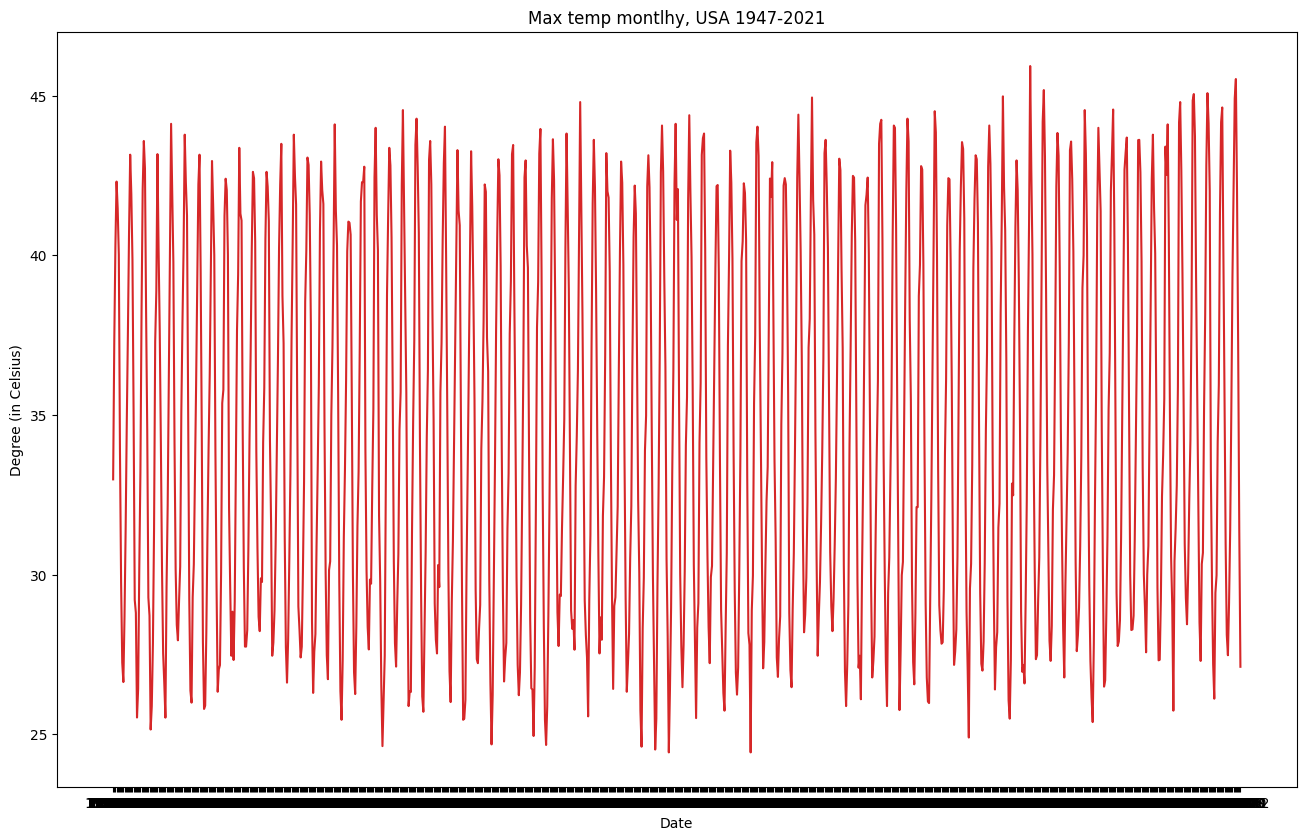

In [90]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df2.index, df2.timeMax, color='tab:red')
plt.gca().set(title="Max temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

In [ ]:
# Apply the Moving Average function by a subset of size 12 months to timeMax.
temp_df_mean = df2.timeMax.rolling(window=12).mean()
temp_df_mean.plot(figsize=(20,15))

Seasonal decomposition: (12 months)

In [ ]:
#FOR time MAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [91]:
dfMax = df2

The stationarity of both the timeseries is ok: so we cak fit a sarimax

In [ ]:
result =adfuller(dfMax)

print('ADF statistics: %f' % result[0])
print('pvalue: %f' % result[1])
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))

Autocorellation and Partial autocorellations suggest a seosonality of 12 months for both

In [ ]:
fig,ax = plt.subplots(2, figsize=(12,6))
ax[0]= plot_acf(dfMax, ax=ax[0],lags=365)
ax[1]= plot_pacf(dfMax, ax=ax[1],lags=365)

------------------------------------------------------------------------------------------------------------FIRST MODEL---------------------------------------------------------------------------------------------------------------------

--------------------HERE only on dfMAX, then when we pick the best ----------------------------approach we'll do also for dfMin (it will be the same)----------

NO TEST AND TRAINING DATA: https://github.com/imkhoa99/Time-Series-Analysis-and-Weather-Forecast-/blob/master/Time_Series_Project.ipynb

The sarima model. First search for the best AIC then train the model

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfMax,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

In [ ]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

In [ ]:
# Fit the SARIMAX model using optimal parameters i.e First line
#{((1, 1, 1), (0, 1, 1, 12)): 3176.7977630048667,
mod = sm.tsa.statespace.SARIMAX(dfMax,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-05-15'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
ax = dfMax['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = dfMax['2018-05-15':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {} (degrees)'.format(round(mse, 2)))

------------------------------------------------------------------------------------------------------------SECOND MODEL---------------------------------------------------------------------------------------------------------------------

I have manually divided the dataset into Training and Test (last year). Since it was important to keep the index the Training is just the dataset with Nan values for the last 12 months. Is it a reasonable approach? 

In [ ]:
train = dfMax.copy()
test = dfMax[(len(dfMax)-12):]
train[-12:] = float("NAN")

In [ ]:
train

In [ ]:
test

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

In [ ]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

In [ ]:
#{((1, 1, 1), (0, 1, 1, 12)): 3131.7648817455993,
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

1 year prediction: original data vs predictions figsize=(20, 15)

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
ax = dfMax['2019':].plot(label='observed', figsize=(10, 10))
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_ci = pred.predicted_mean
mse = MSE(test, pred_ci, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

------------------------------------------------------------------------------------------------------------THIRD MODEL---------------------------------------------------------------------------------------------------------------------

Prediction with another code for the model- Here it's easy to change how many years to predict. With the previous one I don't know if inputing more than 1 year of Nan it's cool. here no Nan...
Maybe it's a cleaner model and code..
here trying 12 months test set but it's easy to change.

In [92]:
len(dfMax)

993

In [93]:
993-12

981

In [94]:
train1 = dfMax[:981]
test1 = dfMax[981:]

In [95]:
smodel = pm.auto_arima(train1, start_p=1, start_q=1,
                         #test2='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3406.427, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3183.119, Time=1.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3404.467, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3371.026, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3096.568, Time=4.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.23 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.37 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3146.969, Time=3.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3087.883, Time=4.40 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3169.554, Time=1.18 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=21.86 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=3089

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1538.031
Date:                            Fri, 28 May 2021   AIC                           3086.062
Time:                                    00:54:43   BIC                           3110.443
Sample:                                         0   HQIC                          3095.342
                                            - 981                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2062      0.031      6.696      0.000       0.146       0.267
ar.L2          0.1051      0.031      3.350      0.001       0.044       0.167
ar.S.L12      -0.5503      0.030    -18.353      0.000      -0.609      -0.492
ar.S.L24      -0.2909      0.031     -9.328      0.000      -0.352      -0.230
sigma2         1.3935      0.063     21.959      0.000       1.269       1.518
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.96   Prob(JB):                         0.85
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

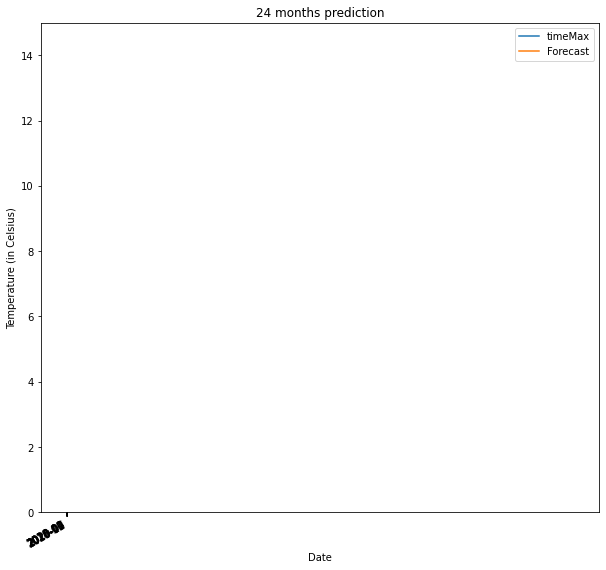

In [101]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train1.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
ax = dfMax['2018':].plot(label='observed', figsize=(10, 10))
fitted_series.plot(ax=ax, label='Forecast')

ax.fill_between(lower_series.index,
                lower_series,
               upper_series, color='k', alpha=.15)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.title("24 months prediction")
plt.show()

In [100]:
fitted_series.plot(ax=ax, label='Forecast')

<AxesSubplot:xlabel='time'>

In [97]:
mse = MSE(test1, fitted_series, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.41


Thank for watching, this is madness = follie https://www.youtube.com/watch?v=0vF0xd9h63Y&feature=youtu.be